In [93]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
import imageio

In [94]:
def load_dataset():
    train_dataset = h5py.File('./sample_data/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

    test_dataset = h5py.File('./sample_data/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [95]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


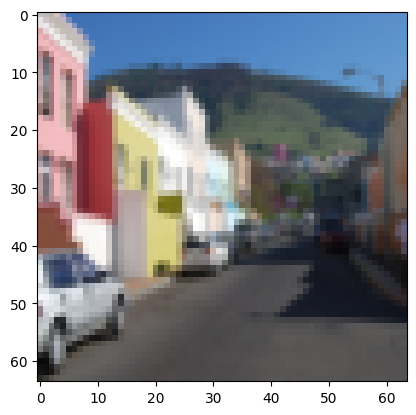

In [96]:
index = 1
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [97]:
# Find the values for:
#    - m_train (number of training examples)
#    - m_test (number of test examples)
#    - num_px
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig[0].shape[0]

In [98]:
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [99]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [100]:
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print("original image first 5 pixels: " + str(train_set_x_orig[0, 0:5, 0, 0]))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
original image first 5 pixels: [17 25 32 36 40]
sanity check after reshaping: [17 31 56 22 33]


In [101]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [102]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [103]:
def initialize_with_zeros(dim):
    return np.zeros([dim, 1]), 0.0

In [104]:
def propagate(w, b, X, Y):
    m = X.shape[1]

    # FORWARD PROPAGATION
    A = sigmoid(np.dot(w.T, X) + b)                                 # compute activation
    cost = -np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) / m     # compute cost

    # BACKWARD PROPAGATION
    dw = np.dot(X, (A - Y).T) / m
    db = np.sum(A - Y) / m

    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [105]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []

    for i in range(num_iterations):

        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule
        w = w - learning_rate * dw
        b = b - learning_rate * db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [106]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    A = sigmoid(np.dot(w.T, X) + b)

    for i in range(A.shape[1]):
        Y_prediction[0][i] = 1 if A[0][i] > 0.5 else 0

    return Y_prediction

In [107]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [108]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 200, learning_rate = 0.01, print_cost = True)

Cost after iteration 0: 0.693147


Cost after iteration 100: 0.823921
train accuracy: 84.21052631578948 %
test accuracy: 80.0 %


It is  b'non-cat'


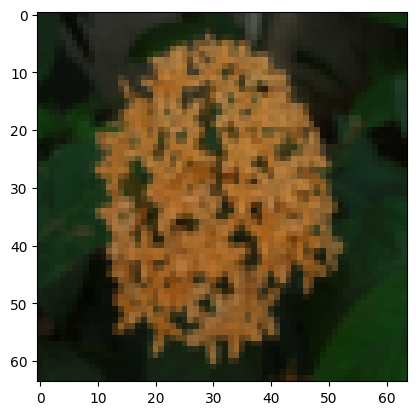

In [109]:
index = 43
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print('It is ', classes[int(d["Y_prediction_test"][0,index])])

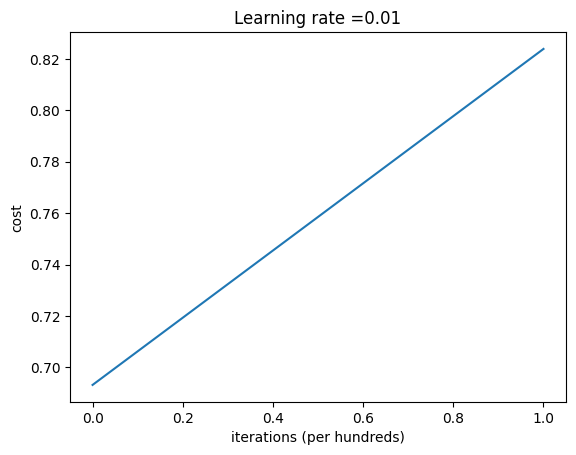

In [110]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [111]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



## Візуалізація залежності Cost від ітерацій

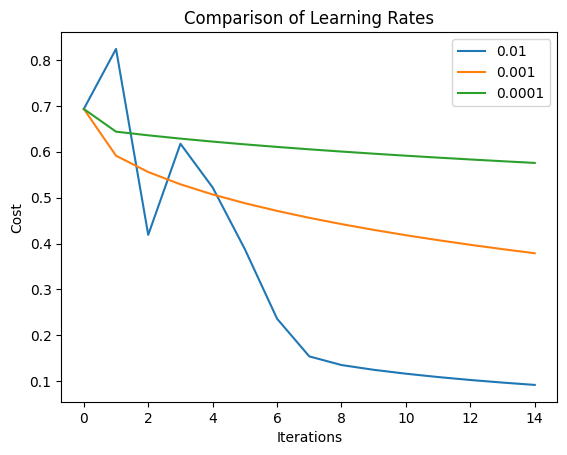

In [112]:
for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.title("Comparison of Learning Rates")
plt.legend()
plt.show()

Графік показує, що великий learning rate (α=0.01) швидко знижує функцію втрат, тоді як маленькі значення призводять до повільної збіжності.

C:\Users\Todmount\AppData\Local\Temp\ipykernel_9176\3094107951.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = np.array(imageio.imread(fname))


y = 1.0, your algorithm predicts a "cat" picture.


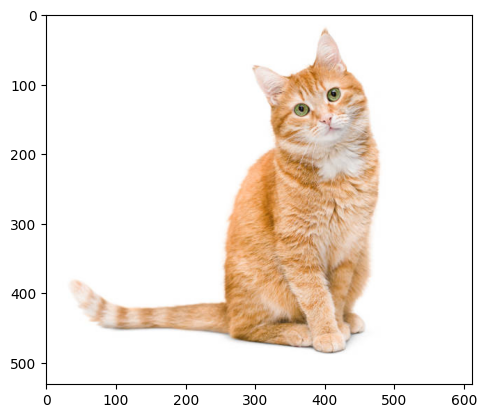

In [113]:
fname = "./sample_data/pure_cat.png" # ENTER your image here
image = np.array(imageio.imread(fname))
my_image =np.array(Image.fromarray(image).resize(size=(num_px,num_px))).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

Mission failed!

# Тестування моделі на інших наборах даних

In [145]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Завантаження Iris датасету
iris = load_iris()

# Вибираємо лише два класи: Setosa (0) і Versicolor (1)
mask = iris.target != 2  # Відкидаємо "Virginica"
X = iris.data[mask]      # Фічі (довжина і ширина пелюсток та чашолистків)
Y = iris.target[mask]    # Мітки класів (0 і 1)

# Транспонуємо дані для відповідності моделі
X = X.T
Y = Y.reshape(1, -1)

# Розділяємо дані на навчальний та тестовий набір
X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y.T, test_size=0.2, random_state=42)

# Стандартизуємо дані (нормалізація)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).T
X_test = scaler.transform(X_test).T

In [146]:
# Імпортуємо реалізовані функції
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Ініціалізація параметрів
def initialize_with_zeros(dim):
    return np.zeros([dim, 1]), 0.0

# Forward і Backward propagation
def propagate(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A)) / m

    dw = np.dot(X, (A - Y).T) / m
    db = np.sum(A - Y) / m

    grads = {"dw": dw, "db": db}
    return grads, cost

# Градієнтний спуск
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    costs = []
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        w -= learning_rate * grads["dw"]
        b -= learning_rate * grads["db"]

        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print(f"Cost after iteration {i}: {cost}")

    return {"w": w, "b": b}, grads, costs

# Прогнозування
def predict(w, b, X):
    A = sigmoid(np.dot(w.T, X) + b)
    return (A > 0.5).astype(int)

# Основна модель
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.01, print_cost=False):
    w, b = initialize_with_zeros(X_train.shape[0])
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    Y_prediction_train = predict(parameters["w"], parameters["b"], X_train)
    Y_prediction_test = predict(parameters["w"], parameters["b"], X_test)

    print("Train accuracy: {:.2f}%".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("Test accuracy: {:.2f}%".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    return {"parameters": parameters, "costs": costs, "Y_prediction_test": Y_prediction_test, "Y_prediction_train": Y_prediction_train}


In [156]:
# Перетворюємо форму ОДИН раз
if X_train.shape[0] > X_train.shape[1]:  # Перевірка, чи потрібно транспонування
    X_train = X_train.T
    X_test = X_test.T

# Переконуємося, що Y_train має форму (1, кількість прикладів)
if Y_train.shape[0] > Y_train.shape[1]:
    Y_train = Y_train.T
    Y_test = Y_test.T

# Запускаємо модель
d = model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.01, print_cost=True)

Cost after iteration 0: 0.6931471805599453
Cost after iteration 100: 0.3137578469194327
Cost after iteration 200: 0.19472479530945486
Cost after iteration 300: 0.14054998269739571
Cost after iteration 400: 0.11004037066729482
Cost after iteration 500: 0.09054737373215103
Cost after iteration 600: 0.07702995021531843
Cost after iteration 700: 0.06710574669390298
Cost after iteration 800: 0.059507754632668775
Cost after iteration 900: 0.05350141211329762
Cost after iteration 1000: 0.048631927680737715
Cost after iteration 1100: 0.044602796481258214
Cost after iteration 1200: 0.04121248545311958
Cost after iteration 1300: 0.03831923273732256
Cost after iteration 1400: 0.03582041399704987
Cost after iteration 1500: 0.033639901568835645
Cost after iteration 1600: 0.03172002520426563
Cost after iteration 1700: 0.030016292606560725
Cost after iteration 1800: 0.028493824500499497
Cost after iteration 1900: 0.02712488803727079
Train accuracy: 100.00%
Test accuracy: 100.00%


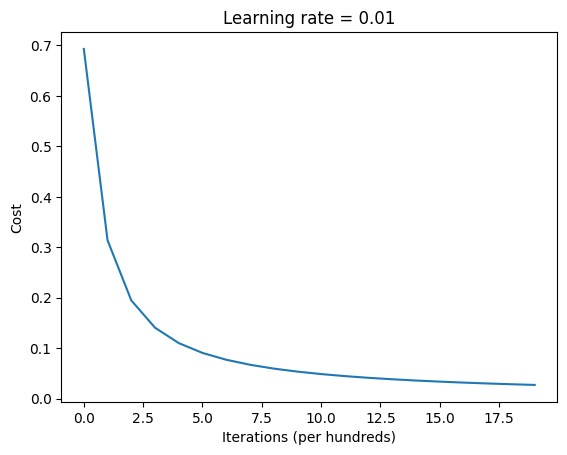

In [157]:
# Побудова графіка функції втрат
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title("Learning rate = 0.01")
plt.show()

## Висновок
Модель логістичної регресії чудово працює для бінарної класифікації Iris dataset, де класи Setosa і Versicolor лінійно роздільні. При правильній нормалізації та налаштуванні learning rate (α=0.01), ми досягаємо високої точності як на тренувальних, так і на тестових даних.